In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Camera Calibration**

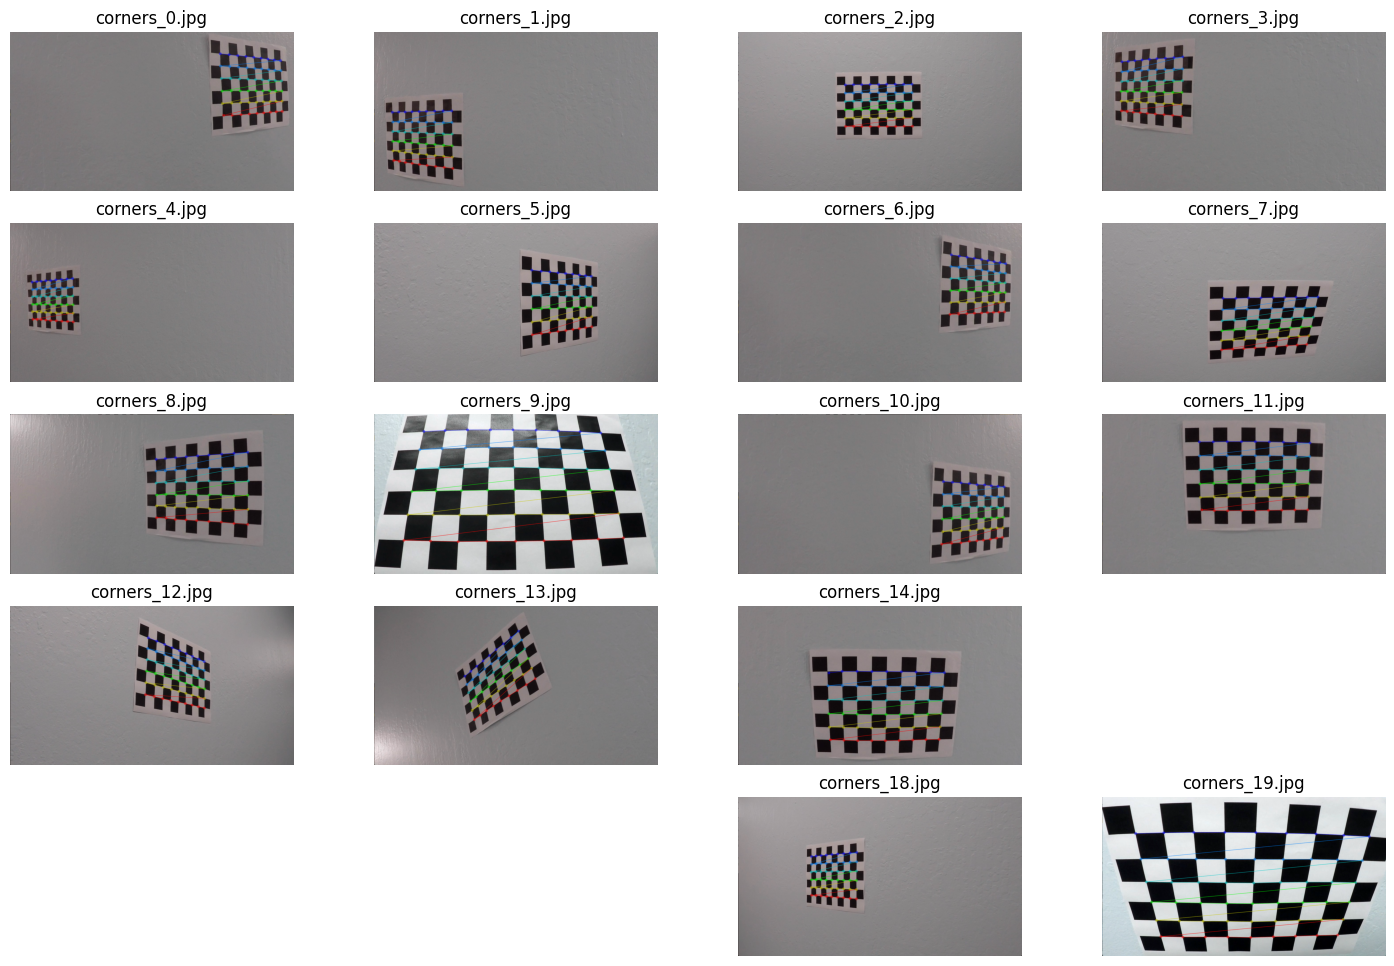

In [ ]:
CHECKERBOARD = (6,9)
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1],3), np.float32)
objp[:,:2] = np.mgrid[0:CHECKERBOARD[1], 0: CHECKERBOARD[0]].T.reshape(-1,2)
objpoints = []
imgpoints = []

images = glob.glob("/content/gdrive/MyDrive/CV Project Data/camera_calib_data/calibration*.jpg")

plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(5,4)
count = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (CHECKERBOARD[1], CHECKERBOARD[0]), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (CHECKERBOARD[1], CHECKERBOARD[0]), corners, ret)
        write_file_name = 'corners_' + str(idx) + '.jpg'
        img_plt = plt.subplot(grid[count])
        plt.axis('on')
        img_plt.set_xticklabels([])
        img_plt.set_yticklabels([])
        #img_plt.set_aspect('equal')
        plt.imshow(img)
        plt.title(write_file_name)
        plt.axis('off')
    count+=1
plt.show()

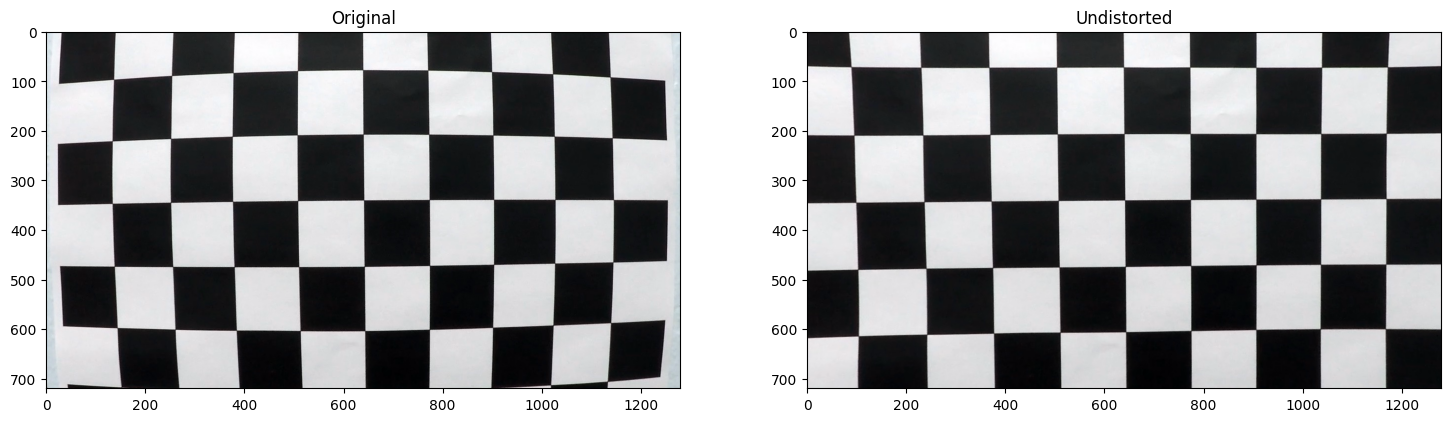

In [ ]:
image = cv2.imread("/content/gdrive/MyDrive/CV Project Data/camera_calib_data/calibration1.jpg")
img_size = (image.shape[1], image.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

calib_pickle = {}
calib_pickle["matrix"] = mtx
calib_pickle["distortion"] = dist
pickle.dump(calib_pickle, open("calibration_pickle.p", "wb"))

undistorted = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

plot_idx = plt.subplot(grid[0])
plt.imshow(image)
plt.title("Original")
plot_idx = plt.subplot(grid[1])
plt.imshow(undistorted)
plt.title("Undistorted")
plt.show()

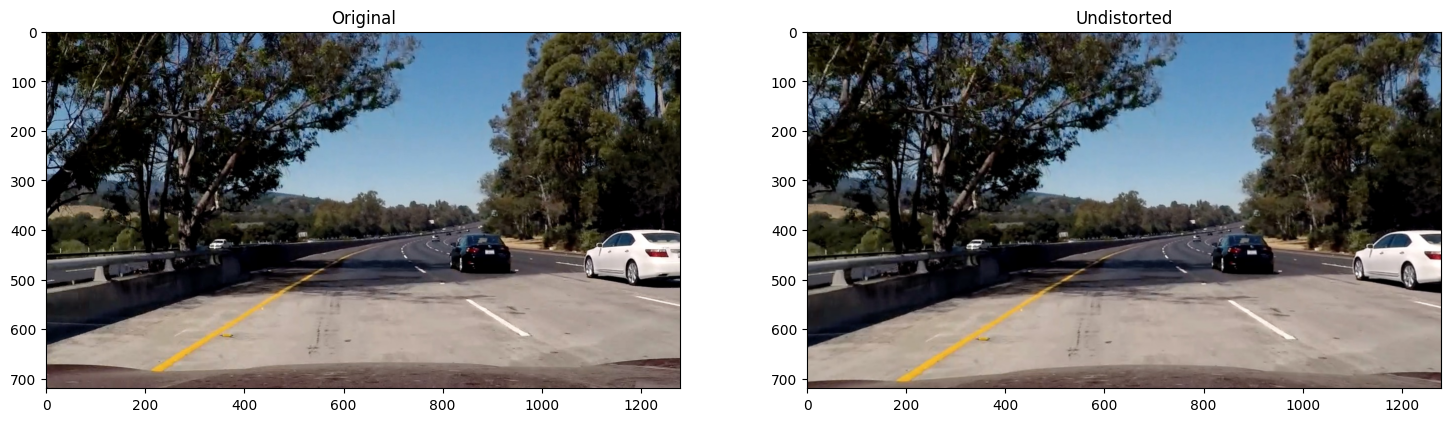

In [ ]:
carImg = cv2.imread("/content/gdrive/MyDrive/CV Project Data/test_images/test5.jpg")
carImg = cv2.cvtColor(carImg, cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(carImg, mtx, dist, None, mtx)

plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

plot_idx = plt.subplot(grid[0])
plt.imshow(carImg)
plt.title("Original")
plot_idx = plt.subplot(grid[1])
plt.imshow(undistorted)
plt.title("Undistorted")
plt.show()

**Preprocessing**

In [ ]:
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

### **Sparsh Checkout these functions**

In [ ]:
import scipy.signal
import scipy.fft
from scipy import ndimage, misc

In [ ]:
def zerocrosshelper(logimg, i, j,threshx,threshy):
  if(logimg[i-1][j]*logimg[i+1][j]<0 and np.abs(logimg[i-1][j]-logimg[i+1][j])>threshx):
      return 1
  if(logimg[i][j-1]*logimg[i][j+1]<0 and np.abs(logimg[i][j-1]-logimg[i][j+1])>threshy):
      return 1
  if(logimg[i-1][j-1]*logimg[i+1][j+1]<0 and np.abs(logimg[i-1][j-1]-logimg[i+1][j+1])>threshx):
      return 1
  if(logimg[i-1][j+1]*logimg[i+1][j-1]<0 and np.abs(logimg[i-1][j+1]-logimg[i+1][j-1])>threshx):
      return 1
  return 0

def zeroCrossing(img):
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  l_channel = hls[:,:,1]
  height = l_channel.shape[0]
  width = l_channel.shape[1]
  print(l_channel.shape)
  box_filter= np.ones((3,3),dtype=float)
  box_filter = box_filter/9
  blurred_img = scipy.signal.convolve2d(l_channel, box_filter)
  blurred_img = blurred_img[:height, :width]
  result = ndimage.gaussian_laplace(blurred_img, sigma=2)
  zc = np.zeros((height,width))
  mean = np.mean(np.abs(result))
  threshx = 0.2*np.max(result)
  threshy = 0.35*np.max(result)

  for i in range(1,height-1):
    for j in range(1,width-1):
        zc[i][j] = zerocrosshelper(result, i, j,threshx,threshy)
  zc = np.float32(zc)
  median = cv2.medianBlur(zc, 5)
  return median

def sobelxFFT(img,thresh_min=20, thresh_max=100):
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  l_channel = hls[:,:,1]
  kernel=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  fftkernel = scipy.fft.fft2(kernel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftkernel = scipy.fft.fftshift(fftkernel)
  fftl_channel = scipy.fft.fft2(l_channel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftl_channel = scipy.fft.fftshift(fftl_channel)
  result = fftl_channel*fftkernel
  result = scipy.fft.ifftshift(result)
  result = scipy.fft.ifft2(result)
  result = result[:l_channel.shape[0], :l_channel.shape[1]]
  result = result.real
  result = np.abs(result)
  result = np.uint8(255*result/np.max(result))
  binary_output = np.zeros_like(result)
  binary_output[(result >= thresh_min) & (result <= thresh_max)] = 1

  return binary_output

def sobelyFFT(img,thresh_min=20, thresh_max=100):
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  l_channel = hls[:,:,1]
  kernel=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
  fftkernel = scipy.fft.fft2(kernel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftkernel = scipy.fft.fftshift(fftkernel)
  fftl_channel = scipy.fft.fft2(l_channel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftl_channel = scipy.fft.fftshift(fftl_channel)
  result = fftl_channel*fftkernel
  result = scipy.fft.ifftshift(result)
  result = scipy.fft.ifft2(result)
  result = result[:l_channel.shape[0], :l_channel.shape[1]]
  result = result.real
  result = np.abs(result)
  result = np.uint8(255*result/np.max(result))
  binary_output = np.zeros_like(result)
  binary_output[(result >= thresh_min) & (result <= thresh_max)] = 1
  return binary_output

def laplacianFFT(img,thresh_min=20, thresh_max=255):
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  l_channel = hls[:,:,1]
  kernel=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
  # kernel=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
  fftkernel = scipy.fft.fft2(kernel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftkernel = scipy.fft.fftshift(fftkernel)
  fftl_channel = scipy.fft.fft2(l_channel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftl_channel = scipy.fft.fftshift(fftl_channel)
  result = fftl_channel*fftkernel
  result = scipy.fft.ifftshift(result)
  result = scipy.fft.ifft2(result)
  result = result[:l_channel.shape[0], :l_channel.shape[1]]
  result = result.real
  result = np.abs(result)
  result = np.uint8(255*result/np.max(result))
  binary_output = np.zeros_like(result)
  binary_output = cv2.medianBlur(binary_output,3)
  binary_output[(result >= thresh_min) & (result <= thresh_max)] = 1
  return binary_output

def laplacianGaussianFFT(img,thresh_min=25, thresh_max=255):
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  l_channel = hls[:,:,1]
  kernel=np.array([[0,0,-1,0,0],[0,-1,-2,-1,0],[-1,-2,16,-2,-1],[0,-1,-2,-1,0],[0,0,-1,0,0]])
  fftkernel = scipy.fft.fft2(kernel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftkernel = scipy.fft.fftshift(fftkernel)
  fftl_channel = scipy.fft.fft2(l_channel,(l_channel.shape[0]+kernel.shape[0]-1, l_channel.shape[1]++kernel.shape[1]-1))
  fftl_channel = scipy.fft.fftshift(fftl_channel)
  result = fftl_channel*fftkernel
  result = scipy.fft.ifftshift(result)
  result = scipy.fft.ifft2(result)
  result = result[:l_channel.shape[0], :l_channel.shape[1]]
  result = result.real
  result = np.abs(result)
  result = np.uint8(255*result/np.max(result))
  binary_output = np.zeros_like(result)
  binary_output = cv2.medianBlur(binary_output,3)
  binary_output[(result >= thresh_min) & (result <= thresh_max)] = 1
  return binary_output

def preprocessSobel(img):
  prepImg = np.zeros_like(img[:,:,0])
  imgx = sobelxFFT(img,thresh_min=15, thresh_max=255)
  imgy = sobelxFFT(img,thresh_min=25, thresh_max=255)
  c_img = color_threshold(img, sthresh=(90,255), vthresh=(60,255))
  prepImg[((imgx == 1) & (imgy ==1) | (c_img == 1))] = 255
  return prepImg

def preprocessZeroCrossing(img):
  prepImg = np.zeros_like(img[:,:,0])
  zcImg = zeroCrossing(img)
  c_img = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
  prepImg[((zcImg==1) | (c_img == 1))] = 255
  return prepImg

def preprocessLoG(img):
  prepImg = np.zeros_like(img[:,:,0])
  logImg = laplacianGaussianFFT(img)
  c_img = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
  prepImg[((logImg ==1) | (c_img == 1))] = 255
  return prepImg

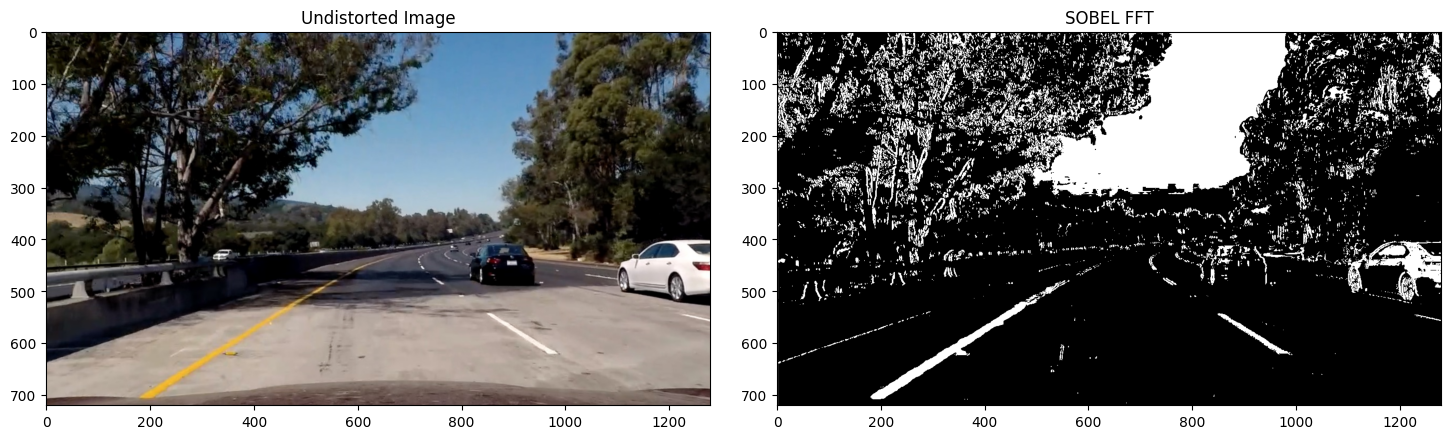

In [ ]:
#Apply Sobel operator in X-direction to experiment with gradient thresholds
carImg = cv2.imread("/content/gdrive/MyDrive/CV Project Data/test_images/test5.jpg")
carImg = cv2.cvtColor(carImg, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(carImg, mtx, dist, None, mtx)

procressed_image = preprocessSobel(undistorted)

#Visualize the results before/after absolute sobel operator is applied on a test image in x direction to find the
#vertical lines, since the lane lines are close to being vertical
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistorted, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(procressed_image, cmap="gray")
plt.title('SOBEL FFT')

plt.show()

(720, 1280)


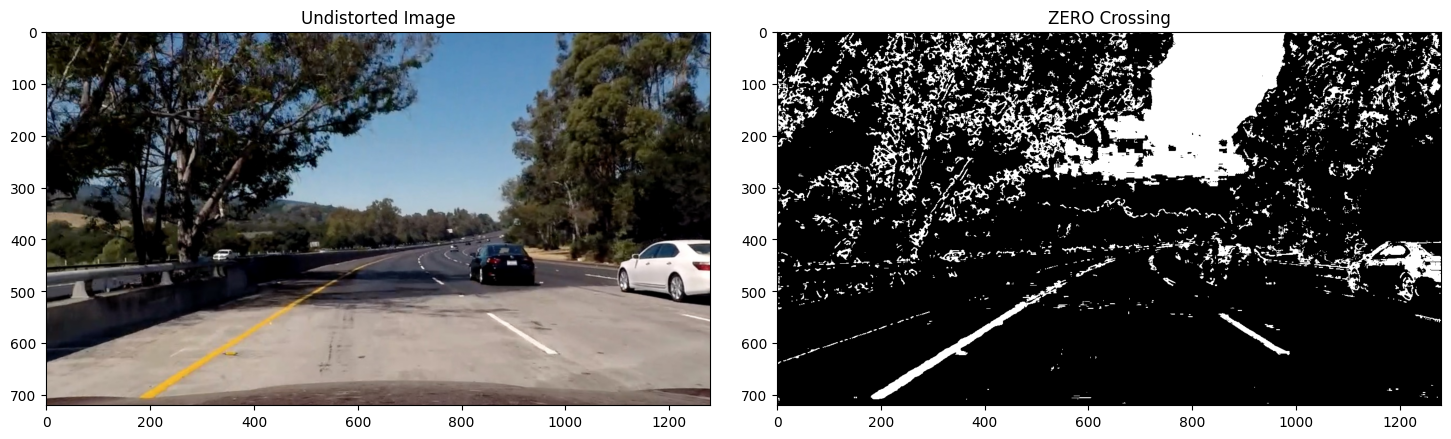

In [ ]:
#Apply Sobel operator in X-direction to experiment with gradient thresholds
carImg = cv2.imread("/content/gdrive/MyDrive/CV Project Data/test_images/test5.jpg")
carImg = cv2.cvtColor(carImg, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(carImg, mtx, dist, None, mtx)

procressed_image = preprocessZeroCrossing(undistorted)

#Visualize the results before/after absolute sobel operator is applied on a test image in x direction to find the
#vertical lines, since the lane lines are close to being vertical
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistorted, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(procressed_image, cmap="gray")
plt.title('ZERO Crossing')

plt.show()

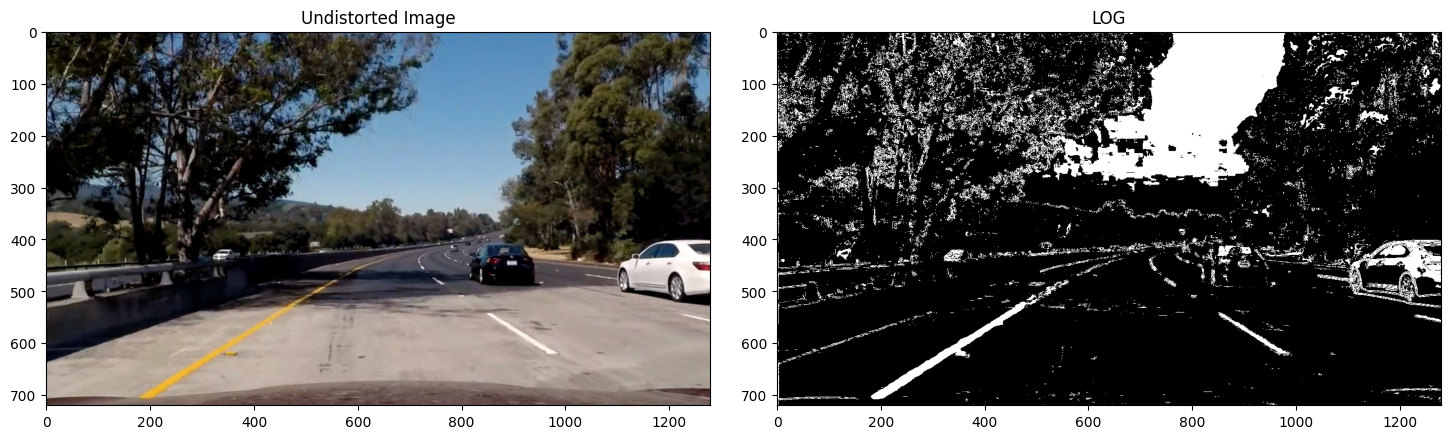

In [ ]:
#Apply Sobel operator in X-direction to experiment with gradient thresholds
carImg = cv2.imread("/content/gdrive/MyDrive/CV Project Data/test_images/test5.jpg")
carImg = cv2.cvtColor(carImg, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(carImg, mtx, dist, None, mtx)

procressed_image = preprocessLoG(undistorted)

#Visualize the results before/after absolute sobel operator is applied on a test image in x direction to find the
#vertical lines, since the lane lines are close to being vertical
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistorted, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(procressed_image, cmap="gray")
plt.title('LOG')

plt.show()

(720, 1280)
(1280, 720)
(720, 1280)
(1280, 720)
(720, 1280)
(1280, 720)
(720, 1280)
(1280, 720)
(720, 1280)
(1280, 720)
(720, 1280)
(1280, 720)
(720, 1280)
(1280, 720)
(720, 1280)
(1280, 720)


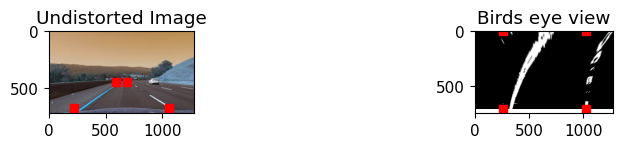

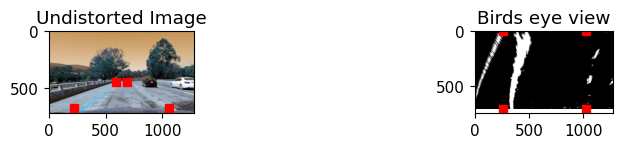

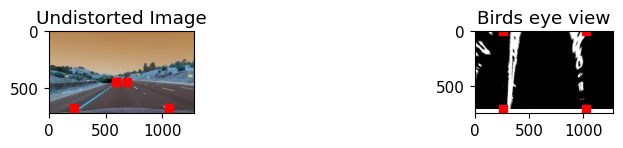

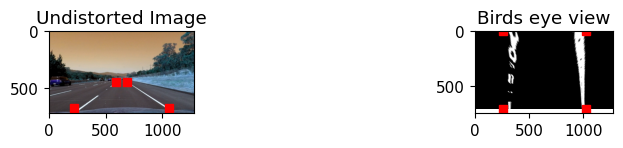

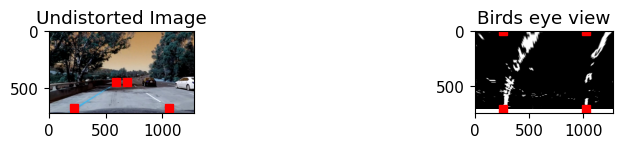

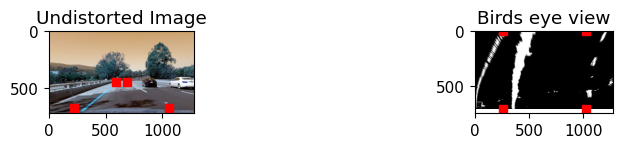

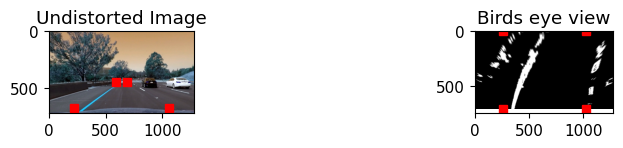

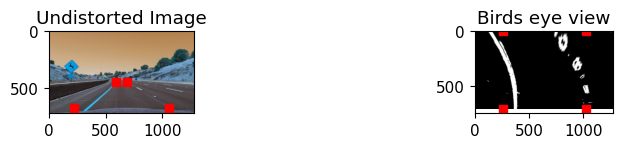

In [ ]:
images = glob.glob('/content/gdrive/MyDrive/CV Project Data/test_images/*.jpg')
gidx = 0
for idx,fname in enumerate(images):
    img_size = (img.shape[1],img.shape[0])
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 0, img_size)
    img = cv2.undistort(img,newcameramtx,dist,None,newcameramtx)
    
    #pass image thru the pipeline
    preprocessImage = preprocessZeroCrossing(img)
    
    print(img_size)

    #parameter tuning karni hogi ispe 
    bot_width = .65
    top_width = .08
    height_pct = .62 
    bottom_trim= .93


    src = np.float32([[img.shape[1]*(0.5-top_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+top_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.2
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    #homography with 4 points
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    plt.figure(figsize = (10,10))
    grid = gridspec.GridSpec(8,2)

    plt.subplot(grid[gidx])
    plt.imshow(img, cmap="gray")
    for i in range(4):
        plt.plot(src[i][0],src[i][1],'rs')
    plt.title('Undistorted Image')

    plt.subplot(grid[gidx+1])
    plt.imshow(warped, cmap="gray")
    for i in range(4):
        plt.plot(dst[i][0],dst[i][1],'rs')
    plt.title('Birds eye view')
    write_name='/content/gdrive/MyDrive/CV Project Data/plots/ZERO_CROSSING/'+str(idx)+'.jpg'
    write_name2='/content/gdrive/MyDrive/CV Project Data/plots/ZERO_CROSSING/undistored'+str(idx)+'.jpg'

    cv2.imwrite(write_name, warped)
    cv2.imwrite(write_name2, img)
plt.show()

In [ ]:
class tracker():
    def __init__(self, window_width, window_height, margin, ym = 1, xm = 1, smoothing = 15):
        self.centers = []
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.ym = ym 
        self.xm = xm
        self.smoothing = smoothing
    
    def findCentroid(self, warped):
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin 

        centroids = []
        conv_window = np.ones(window_width)
        # print(conv_window.shape)
        left_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis = 0)
        # print(left_sum.shape)
        print(np.argmax(np.convolve(conv_window, left_sum)))
        left_center = np.argmax(np.convolve(conv_window, left_sum)) - window_width/2
        right_sum = np.sum(warped[int(3*warped.shape[0]/4):, int(warped.shape[1]/2):],axis = 0)
        right_center = np.argmax(np.convolve(conv_window, right_sum)) - window_width/2 + int(warped.shape[1]/2)

        centroids.append((left_center, right_center))

        for level in range(1,(int)(warped.shape[0]/window_height)):
            img_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height), :], axis = 0)
            conv_signal = np.convolve(conv_window, img_layer)
            offset = window_width/2
            left_min_index = int(max(left_center + offset - margin, 0))
            left_max_index = int(min(left_center + offset + margin, warped.shape[1]))
            left_center = np.argmax(conv_signal[left_min_index: left_max_index]) + left_min_index - offset
            right_min_index = int(max(right_center + offset - margin,0))
            right_max_index = int(min(right_center + offset + margin, warped.shape[1]))
            right_center = np.argmax(conv_signal[right_min_index:right_max_index]) + right_min_index - offset
            centroids.append((left_center, right_center))
        self.centers.append(centroids)

        return np.average(self.centers[-self.smoothing:], axis = 0)


(720, 1280)
(1280, 720)
(720, 1280)
378


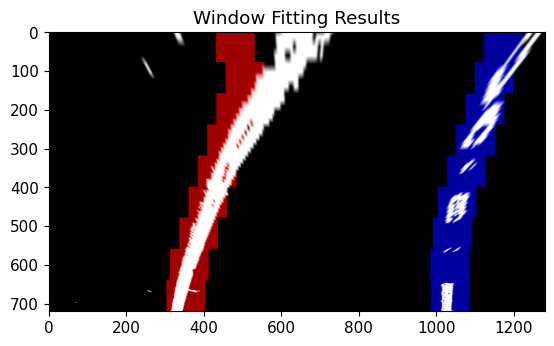

(720, 1280)
(1280, 720)
(720, 1280)
366


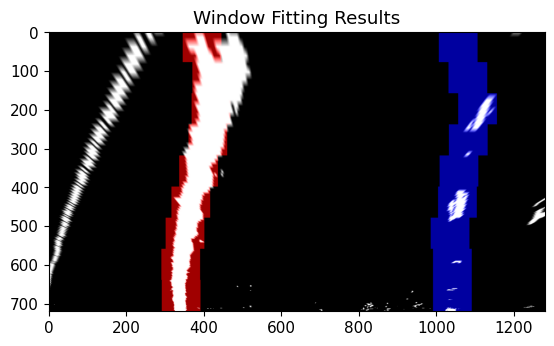

(720, 1280)
(1280, 720)
(720, 1280)
346


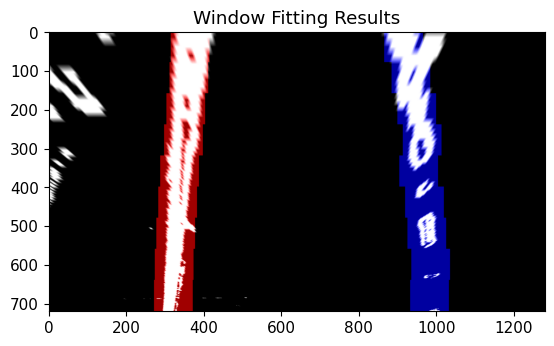

(720, 1280)
(1280, 720)
(720, 1280)
345


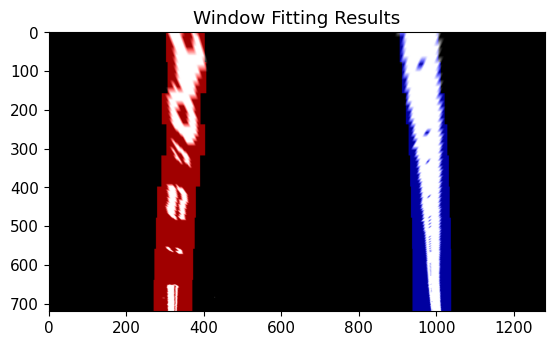

(720, 1280)
(1280, 720)
(720, 1280)
313


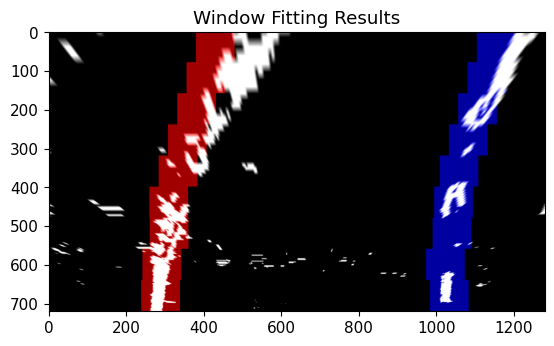

(720, 1280)
(1280, 720)
(720, 1280)
388


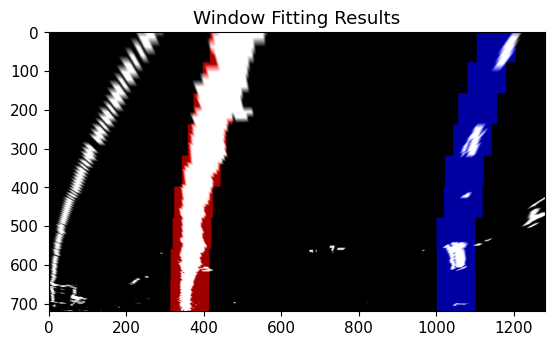

(720, 1280)
(1280, 720)
(720, 1280)
394


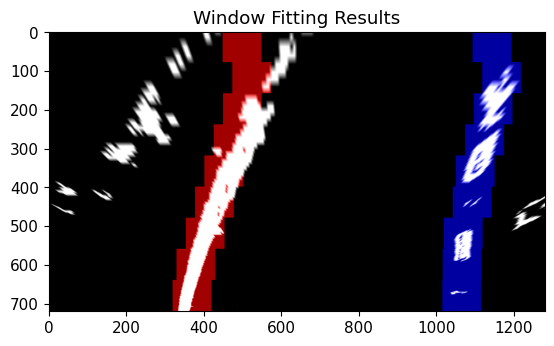

(720, 1280)
(1280, 720)
(720, 1280)
395


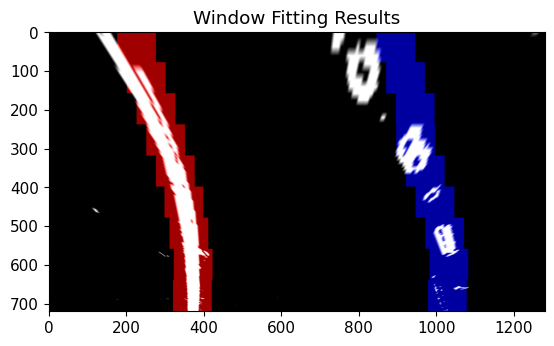

In [ ]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # img = cv2.undistort(img,mtx,dist,None,mtx)
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 0, img_size)
    img = cv2.undistort(img,newcameramtx,dist,None,newcameramtx)

    preprocessImage = preprocessZeroCrossing(img)

    # preprocessImage = np.zeros_like(img[:,:,0])
    # gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    # grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    # c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    # preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1],img.shape[0])
    print(img_size)

    #parameter tuning karni hogi ispe 
    bot_width = .65
    top_width = .08
    height_pct = .62 
    bottom_trim= .93


    src = np.float32([[img.shape[1]*(0.5-top_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+top_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.2
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    #homography with 4 points
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)
    print(warped.shape)
    width = 50
    height = 80

    curve_centers = tracker(width, height, 25, 10/720, 4/384, 15)
    centroids = curve_centers.findCentroid(warped)

    left_points = np.zeros_like(warped)
    right_points = np.zeros_like(warped)

    rightlane = []
    leftlane = []

    for level in range(0, len(centroids)):
        leftlane.append(centroids[level][0])
        rightlane.append(centroids[level][1])

        left_mask = window_mask(width, height,warped,centroids[level][0], level)
        right_mask = window_mask(width, height,warped,centroids[level][1],level)

        left_points[(left_points == 255) | ((left_mask == 1))] = 200
        right_points[(right_points == 255) | ((right_mask == 1))] = 200

    left_windows = np.array(left_points, np.uint8)
    right_windows = np.array(right_points, np.uint8)
    zero_channel = np.zeros_like(left_points)
    leftist = np.array(cv2.merge((left_windows,zero_channel, zero_channel)), np.uint8)
    rightist = np.array(cv2.merge((zero_channel, zero_channel, right_windows)), np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)), np.uint8)
    result = cv2.addWeighted(warpage, 1, leftist, 0.8, 0.0)
    result = cv2.addWeighted(result, 1, rightist, 0.8, 0.0)

    plt.imshow(result, cmap = 'gray')
    plt.title('Window Fitting Results')
    write_name='/content/gdrive/MyDrive/CV Project Data/plots/ZERO_CROSSING/WindowFitting'+str(idx)+'.jpg'
    # write_name2='/content/gdrive/MyDrive/CV Project Data/plots/SOBEL/undistored'+str(idx)+'.jpg'

    cv2.imwrite(write_name, result)
    # cv2.imwrite(write_name2, img)
    plt.show()


(720, 1280)
378
[-0.00016098    -0.13076      505.03]
(720, 1280)
366
[ -0.0001921   0.0062284      411.63]
(720, 1280)
346
[  4.143e-05    -0.10337      370.63]
(720, 1280)
345
[-2.8409e-05   -0.038712       356.5]
(720, 1280)
313
[ 0.00024317    -0.40341      448.12]
(720, 1280)
388
[ 0.00023471    -0.33566      480.96]
(720, 1280)
394
[-0.00016572    -0.12818       521.8]
(720, 1280)
395
[-0.00027056     0.43564      204.33]


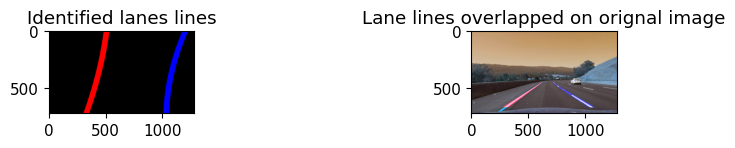

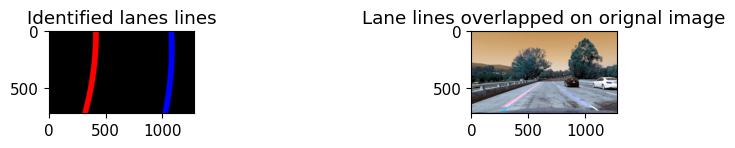

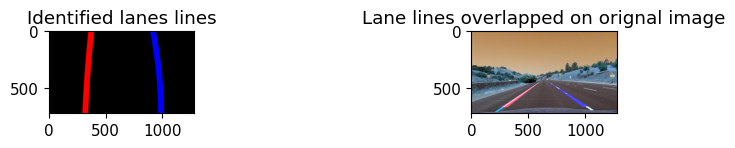

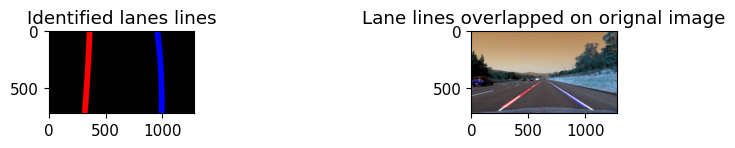

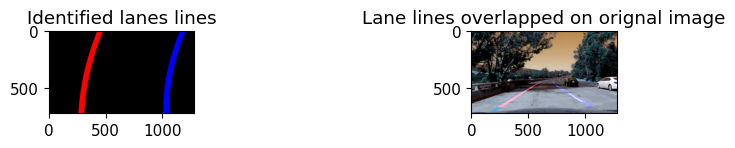

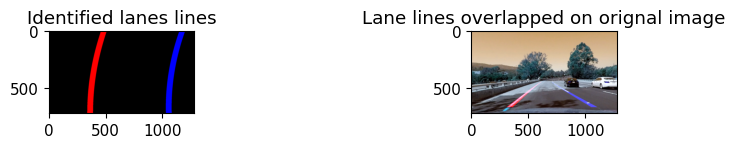

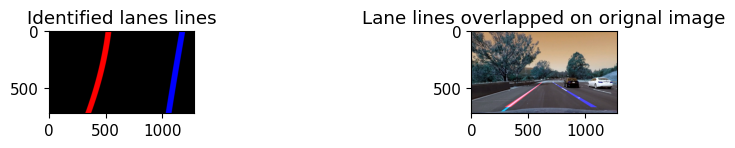

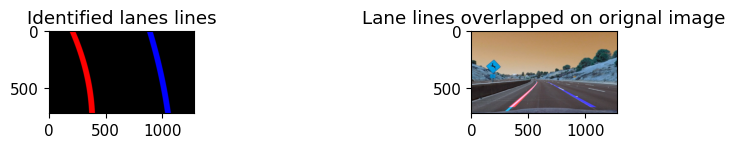

In [ ]:
gidx = 0

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    #undistort the image
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 0, img_size)
    img = cv2.undistort(img,newcameramtx,dist,None,newcameramtx)
    
    #pass image thru the pipeline
    preprocessImage = preprocessZeroCrossing(img)

    #parameter tuning karni hogi ispe 
    bot_width = .65
    top_width = .08
    height_pct = .62 
    bottom_trim= .93


    src = np.float32([[img.shape[1]*(0.5-top_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+top_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.2
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    #homography with 4 points
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)
    # print(warped.shape)
    width = 50
    height = 80

    curve_centers = tracker(width, height, 25, 10/720, 4/384, 15)
    centroids = curve_centers.findCentroid(warped)

    left_points = np.zeros_like(warped)
    right_points = np.zeros_like(warped)

    rightlane = []
    leftlane = []

    for level in range(0, len(centroids)):
        leftlane.append(centroids[level][0])
        rightlane.append(centroids[level][1])

        left_mask = window_mask(width, height,warped,centroids[level][0], level)
        right_mask = window_mask(width, height,warped,centroids[level][1],level)

        left_points[(left_points == 255) | ((left_mask == 1))] = 200
        right_points[(right_points == 255) | ((right_mask == 1))] = 200

    left_windows = np.array(left_points, np.uint8)
    right_windows = np.array(right_points, np.uint8)
    zero_channel = np.zeros_like(left_points)
    leftist = np.array(cv2.merge((left_windows,zero_channel, zero_channel)), np.uint8)
    rightist = np.array(cv2.merge((zero_channel, zero_channel, right_windows)), np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)), np.uint8)
    result = cv2.addWeighted(warpage, 1, leftist, 0.8, 0.0)
    result = cv2.addWeighted(result, 1, rightist, 0.8, 0.0)

    y = range(0,warped.shape[0])
    residuals = np.arange(warped.shape[0]- (height/2),0,-height)

    left_fitter = np.polyfit(residuals, leftlane, 2)
    print(left_fitter)
    left_fit_lane = left_fitter[0]*y*y + left_fitter[1]*y + left_fitter[2]
    left_fit_lane = np.array(left_fit_lane, np.int32)

    right_fitter = np.polyfit(residuals, rightlane, 2)
    right_fit_lane = right_fitter[0]*y*y + right_fitter[1]*y + right_fitter[2]
    right_fit_lane = np.array(right_fit_lane, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fit_lane-width/2, left_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fit_lane-width/2, right_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)
    
    road = np.zeros_like(img)
    road_background = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color = [255,0,0])
    cv2.fillPoly(road, [right_lane], color = [0,0,255])
    cv2.fillPoly(road_background, [left_lane], color = [255,0,0])
    cv2.fillPoly(road_background, [right_lane], color = [0,0,255])

    road_warped = cv2.warpPerspective(road, Minv, img_size, flags = cv2.INTER_LINEAR)
    road_background_warped = cv2.warpPerspective(road_background, Minv, img_size, flags = cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped, -1, 0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1, 0)

    plt.figure(figsize = (10,10))
    grid = gridspec.GridSpec(8,2)
    
    plt.subplot(grid[gidx])
    plt.imshow(road, cmap="gray")
    plt.title('Identified lanes lines')
    plt.subplot(grid[gidx+1])
    plt.imshow(result, cmap = "gray")
    plt.title("Lane lines overlapped on orignal image")
    write_name='/content/gdrive/MyDrive/CV Project Data/plots/ZERO_CROSSING/OverLap'+str(idx)+'.jpg'
    write_name2='/content/gdrive/MyDrive/CV Project Data/plots/ZERO_CROSSING/Lines'+str(idx)+'.jpg'

    cv2.imwrite(write_name, result)
    cv2.imwrite(write_name2, road)
plt.show()



In [22]:
gidx = 0
images = glob.glob('/content/gdrive/MyDrive/CV Project Data/test_images/*.jpg')
for idx, fname in enumerate(images):

    img = cv2.imread(fname)
    #undistort the image
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 0, img_size)
    img = cv2.undistort(img,newcameramtx,dist,None,newcameramtx)
    
    #pass image thru the pipeline
    preprocessImage = preprocessLoG(img)

    img_size = (img.shape[1], img.shape[0])

    bot_trap_width = .76
    bot_mid_width = .08
    height_percentage = .62
    bottom_trim = .935

    src = np.float32([[img.shape[1]*(0.5-bot_mid_width/2), img.shape[0]*height_percentage],[img.shape[1]*(0.5+bot_mid_width/2),img.shape[0]*height_percentage],[img.shape[1]*(0.5+bot_trap_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_trap_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])

    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags = cv2.INTER_LINEAR)

    width = 50
    height = 80

    curve_centers = tracker(width, height, 25, 10/720, 4/384, 15)
    centroids = curve_centers.findCentroid(warped)

    left_points = np.zeros_like(warped)
    right_points = np.zeros_like(warped)

    rightlane = []
    leftlane = []

    for level in range(0, len(centroids)):
        leftlane.append(centroids[level][0])
        rightlane.append(centroids[level][1])

        left_mask = window_mask(width, height,warped,centroids[level][0], level)
        right_mask = window_mask(width, height,warped,centroids[level][1],level)

        left_points[(left_points == 255) | ((left_mask == 1))] = 255
        right_points[(right_points == 255) | ((right_mask == 1))] = 255

    template = np.array(right_points + left_points, np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,template, zero_channel)), np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)), np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

    y = range(0,warped.shape[0])
    residuals = np.arange(warped.shape[0]- (height/2),0,-height)

    left_fitter = np.polyfit(residuals, leftlane, 2)
    left_fit_lane = left_fitter[0]*y*y + left_fitter[1]*y + left_fitter[2]
    left_fit_lane = np.array(left_fit_lane, np.int32)

    right_fitter = np.polyfit(residuals, rightlane, 2)
    right_fit_lane = right_fitter[0]*y*y + right_fitter[1]*y + right_fitter[2]
    right_fit_lane = np.array(right_fit_lane, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fit_lane-width/2, left_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fit_lane-width/2, right_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fit_lane-width/2, right_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)

    
    road = np.zeros_like(img)
    road_background = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color = [255,0,0])
    cv2.fillPoly(road, [right_lane], color = [0,0,255])
    cv2.fillPoly(road_background, [left_lane], color = [255,0,0])
    cv2.fillPoly(road_background, [right_lane], color = [0,0,255])

    road_warped = cv2.warpPerspective(road, Minv, img_size, flags = cv2.INTER_LINEAR)
    road_background_warped = cv2.warpPerspective(road_background, Minv, img_size, flags = cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped, -1, 0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1, 0)
    meters_per_pixel_y = curve_centers.xm
    meters_per_pixel_x = curve_centers.ym

    # curve_fit_cr = np.polyfit(np.array(residuals,np.float32)*meters_per_pixel_y,np.array(leftlane,np.float32)*meters_per_pixel_x,2)
    # curverad = ((1 + (2*curve_fit_cr[0]*y[-1]*meters_per_pixel_y+ curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    # camera_center = (left_fit_lane[-1] + right_fit_lane[-1])/2
    # center_diff = (camera_center-warped.shape[1]/2)*meters_per_pixel_x
    # side_pos = 'left'
    # if center_diff <= 0:
    #     side_pos = 'right'
    
    # cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    # cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    plt.imshow(result, cmap='gray')
    plt.title('Final image results')
    plt.show()
    
    write_name='/content/gdrive/MyDrive/CV Project Data/plots/FINALIMAGE2'+str(idx)+'.jpg'
    # write_name2='/content/gdrive/MyDrive/CV Project Data/plots/ZERO_CROSSING/Lines'+str(idx)+'.jpg'

    cv2.imwrite(write_name, result)
    # cv2.imwrite(write_name2, road)



459
448
431
424
411
464
470
466


In [19]:
!pip install filterpy
import torch
import torchvision
import cv2
import sys
sys.path.insert(1,'/content/gdrive/MyDrive/CV Project Data/sort-master')
import matplotlib
from collections import namedtuple, OrderedDict
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (255, 255, 0), (255, 255, 255), (0, 0, 0), 
          (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 0, 128), (128, 128, 0), (128, 128, 128), (255, 128, 0), (128, 255, 0), 
          (0, 128, 255), (255, 0, 128), (255, 255, 128), (128, 255, 255), (255, 128, 255), (192, 192, 192), (128, 128, 255), 
          (255, 0, 0), (255, 255, 0), (0, 255, 0), (0, 128, 128), (255, 0, 255), (128, 0, 128), (0, 255, 255), (0, 0, 255), 
          (165, 42, 42), (0, 128, 128), (255, 165, 0), (255, 192, 203), (128, 0, 0), (128, 128, 0), (0, 128, 0), (128, 128, 128), 
          (0, 128, 128), (0, 0, 128), (0, 0, 255), (255, 0, 0), (255, 255, 0), (0, 255, 0), (0, 128, 128), (255, 0, 255), 
          (128, 0, 128), (0, 255, 255), (0, 0, 255), (165, 42, 42), (0, 128, 128), (255, 165, 0), (255, 192, 203), (128, 0, 0), 
          (128, 128, 0), (0, 128, 0), (128, 128, 128), (0, 128, 128), (0, 0, 128), (0, 0, 255), (255, 0, 0), (255, 255, 0), 
          (0, 255, 0), (0, 128, 128), (255, 0, 255), (128, 0, 128), (0, 255, 255), (0, 0, 255), (165, 42, 42), (0, 128, 128), 
          (255, 165, 0), (255, 192, 203), (128, 0, 0), (128, 128, 0), (0, 128, 0), (128, 128, 128), (0, 128, 128)]
yolov5_detector = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained = True)
yolov5_detector.float()
yolov5_detector.eval()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-8 Python-3.10.11 torch-2.0.0+cu118 CPU



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [42]:
index = strftime()
print(index)

NameError: ignored

In [64]:
gidx = 0
from google.colab.patches import cv2_imshow
def process_image(img,counter):
    # image_index+=1
    img_size = (img.shape[1], img.shape[0])
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 0, img_size)
    img = cv2.undistort(img,newcameramtx,dist,None,newcameramtx)
    preprocessImage = preprocessSobel(img)
    detections = yolov5_detector(img)
    current_detection = []
    for guess in detections.xyxy:
        for i in guess:
            if(int(i[5]) < 2.1 and int(i[5]) > 1.9):
                current_detection.append(i[0:5].numpy().tolist())
    # print(len(current_detection), end = " to ")   
    current_detection = np.array(current_detection)
    

    bot_trap_width = .76
    bot_mid_width = .08
    height_percentage = .62
    bottom_trim = .935

    src = np.float32([[img.shape[1]*(0.5-bot_mid_width/2), img.shape[0]*height_percentage],[img.shape[1]*(0.5+bot_mid_width/2),img.shape[0]*height_percentage],[img.shape[1]*(0.5+bot_trap_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_trap_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])

    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags = cv2.INTER_LINEAR)

    width = 50
    height = 80

    curve_centers = tracker(width, height, 25, 10/720, 4/384, 15)
    centroids = curve_centers.findCentroid(warped)

    left_points = np.zeros_like(warped)
    right_points = np.zeros_like(warped)

    rightlane = []
    leftlane = []

    for level in range(0, len(centroids)):
        leftlane.append(centroids[level][0])
        rightlane.append(centroids[level][1])

        left_mask = window_mask(width, height,warped,centroids[level][0], level)
        right_mask = window_mask(width, height,warped,centroids[level][1],level)

        left_points[(left_points == 255) | ((left_mask == 1))] = 255
        right_points[(right_points == 255) | ((right_mask == 1))] = 255

    template = np.array(right_points + left_points, np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,template, zero_channel)), np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)), np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

    y = range(0,warped.shape[0])
    residuals = np.arange(warped.shape[0]- (height/2),0,-height)

    left_fitter = np.polyfit(residuals, leftlane, 2)
    left_fit_lane = left_fitter[0]*y*y + left_fitter[1]*y + left_fitter[2]
    left_fit_lane = np.array(left_fit_lane, np.int32)

    right_fitter = np.polyfit(residuals, rightlane, 2)
    right_fit_lane = right_fitter[0]*y*y + right_fitter[1]*y + right_fitter[2]
    right_fit_lane = np.array(right_fit_lane, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fit_lane-width/2, left_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fit_lane-width/2, right_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fit_lane-width/2, right_fit_lane[::-1]+width/2),axis=0),np.concatenate((y,y[::-1]),axis=0))),np.int32)

    
    road = np.zeros_like(img)
    road_background = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color = [255,0,0])
    cv2.fillPoly(road, [right_lane], color = [0,0,255])
    cv2.fillPoly(road_background, [left_lane], color = [255,0,0])
    cv2.fillPoly(road_background, [right_lane], color = [0,0,255])

    road_warped = cv2.warpPerspective(road, Minv, img_size, flags = cv2.INTER_LINEAR)
    road_background_warped = cv2.warpPerspective(road_background, Minv, img_size, flags = cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped, -1, 0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1, 0)
    meters_per_pixel_y = curve_centers.xm
    meters_per_pixel_x = curve_centers.ym

    curve_fit_cr = np.polyfit(np.array(residuals,np.float32)*meters_per_pixel_y,np.array(leftlane,np.float32)*meters_per_pixel_x,2)
    curverad = ((1 + (2*curve_fit_cr[0]*y[-1]*meters_per_pixel_y+ curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    camera_center = (left_fit_lane[-1] + right_fit_lane[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*meters_per_pixel_x
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    # cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    # cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    print(counter)
    if(len(current_detection) == 0):
      # cv2_imshow(result)
      print("no detection")
      path = '/content/gdrive/MyDrive/CV Project Data/plots/presentation/final_iamge'+str(rand.randint(0,10000))+'.jpg'
      cv2.imwrite(path, result)
      return result    
    print(f"{len(current_detection)}detection")
    track_bbs_ids = mot_tracker.update(current_detection)
    for det in track_bbs_ids:
      color = colors[int(det[4])%78]
      result = cv2.rectangle(result, (int(det[0]),int(det[1])), (int(det[2]), int(det[3])), color , thickness = 4)
    path = '/content/gdrive/MyDrive/CV Project Data/plots/presentation/final_iamge'+str(rand.randint(0,10000))+'.jpg'
    cv2.imwrite(path, result)
    # cv2.imshow(result)
    #pass image thru the pipeline

    return result

In [ ]:
from sort import *
mot_tracker = Sort()
final_video = 'presentation.mp4'
input_vid = '/content/gdrive/MyDrive/CV Project Data/smaller_video - Made with Clipchamp.mp4'
counter = 0
clip1 = VideoFileClip(input_vid)
video_clip = clip1.fl_image(lambda image:process_image(image, counter=counter+1))
counter+=1
video_clip.write_videofile(final_video, audio = False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
from sort import *
import random as rand
mot_tracker = Sort()
final_video = 'presentation.mp4'
input_vid = '/content/gdrive/MyDrive/CV Project Data/smaller_video - Made with Clipchamp.mp4'
counter = 0
clip1 = VideoFileClip(input_vid)
video_clip = clip1.fl_image(lambda image:process_image(image, counter=counter+1))
counter+=1
video_clip.write_videofile(final_video, audio = False)








































t:   8%|▊         | 27/338 [28:02<12:32,  2.42s/it, now=None]



t:  30%|███       | 103/338 [20:15<05:14,  1.34s/it, now=None]





t:   4%|▎         | 12/338 [17:09<05:55,  1.09s/it, now=None]







t:  10%|█         | 34/338 [29:14<05:08,  1.01s/it, now=None]

t:  30%|███       | 103/338 [33:23<05:30,  1.40s/it, now=None]




t:  10%|█         | 35/338 [18:04<04:56,  1.02it/s, now=None]






t:   9%|▉         | 32/338 [02:06<08:50,  1.73s/it, now=None]























                                                              

463
1
no detection
Moviepy - Building video presentation.mp4.

















t:   8%|▊         | 27/338 [28:02<12:32,  2.42s/it, now=None]



t:  30%|███       | 103/338 [20:15<05:14,  1.34s/it, now=None]





t:   4%|▎         | 12/338 [17:09<05:55,  1.09s/it, now=None]







t:  10%|█         | 34/338 [29:14<05:08,  1.01s/it, now=None]

t:  30%|███       | 103/338 [33:23<05:30,  1.40s/it, now=None]




t:  10%|█         | 35/338 [18:04<04:56,  1.02it/s, now=None]






t:   9%|▉         | 32/338 [02:06<08:50,  1.73s/it, now=None]

Moviepy - Writing video presentation.mp4












t:   0%|          | 0/338 [00:00<?, ?it/s, now=None]








t:   1%|          | 2/338 [00:01<03:23,  1.65it/s, now=None]

463
2
no detection











t:   1%|          | 3/338 [00:02<03:51,  1.45it/s, now=None]

463
2
no detection











t:   1%|          | 4/338 [00:02<04:04,  1.36it/s, now=None]

465
2
no detection











t:   1%|▏         | 5/338 [00:03<04:14,  1.31it/s, now=None]

466
2
no detection











t:   2%|▏         | 6/338 [00:04<04:19,  1.28it/s, now=None]

457
2
no detection











t:   2%|▏         | 7/338 [00:05<04:22,  1.26it/s, now=None]

457
2
no detection











t:   2%|▏         | 8/338 [00:06<04:25,  1.24it/s, now=None]

465
2
no detection











t:   3%|▎         | 9/338 [00:06<04:26,  1.24it/s, now=None]

465
2
no detection











t:   3%|▎         | 10/338 [00:07<04:25,  1.23it/s, now=None]

465
2
no detection











t:   3%|▎         | 11/338 [00:08<04:25,  1.23it/s, now=None]

464
2
no detection











t:   4%|▎         | 12/338 [00:09<04:22,  1.24it/s, now=None]

459
2
no detection











t:   4%|▍         | 13/338 [00:10<04:24,  1.23it/s, now=None]

459
2
no detection











t:   4%|▍         | 14/338 [00:11<04:47,  1.13it/s, now=None]

462
2
no detection











t:   4%|▍         | 15/338 [00:12<05:26,  1.01s/it, now=None]

462
2
no detection











t:   5%|▍         | 16/338 [00:13<05:54,  1.10s/it, now=None]

458
2
no detection











t:   5%|▌         | 17/338 [00:15<06:11,  1.16s/it, now=None]

459
2
no detection











t:   5%|▌         | 18/338 [00:16<06:22,  1.20s/it, now=None]

458
2
no detection











t:   6%|▌         | 19/338 [00:17<06:30,  1.22s/it, now=None]

457
2
no detection











t:   6%|▌         | 20/338 [00:18<06:30,  1.23s/it, now=None]

457
2
no detection











t:   6%|▌         | 21/338 [00:20<06:30,  1.23s/it, now=None]

457
2
no detection











t:   7%|▋         | 22/338 [00:21<06:34,  1.25s/it, now=None]

457
2
no detection











t:   7%|▋         | 23/338 [00:22<05:56,  1.13s/it, now=None]

457
2
no detection











t:   7%|▋         | 24/338 [00:23<05:22,  1.03s/it, now=None]

456
2
no detection











t:   7%|▋         | 25/338 [00:23<05:00,  1.04it/s, now=None]

454
2
no detection











t:   8%|▊         | 26/338 [00:24<04:45,  1.09it/s, now=None]

454
2
no detection











t:   8%|▊         | 27/338 [00:25<04:35,  1.13it/s, now=None]

454
2
no detection











t:   8%|▊         | 28/338 [00:26<04:27,  1.16it/s, now=None]

452
2
no detection











t:   9%|▊         | 29/338 [00:27<04:20,  1.19it/s, now=None]

449
2
no detection











t:   9%|▉         | 30/338 [00:27<04:17,  1.20it/s, now=None]

448
2
no detection











t:   9%|▉         | 31/338 [00:28<04:16,  1.20it/s, now=None]

449
2
no detection











t:   9%|▉         | 32/338 [00:29<04:13,  1.21it/s, now=None]

447
2
no detection











t:  10%|▉         | 33/338 [00:30<04:30,  1.13it/s, now=None]

447
2
no detection











t:  10%|█         | 34/338 [00:31<05:06,  1.01s/it, now=None]

446
2
no detection











t:  10%|█         | 35/338 [00:33<05:32,  1.10s/it, now=None]

444
2
no detection











t:  11%|█         | 36/338 [00:34<05:47,  1.15s/it, now=None]

444
2
no detection











t:  11%|█         | 37/338 [00:35<05:57,  1.19s/it, now=None]

444
2
no detection











t:  11%|█         | 38/338 [00:37<06:03,  1.21s/it, now=None]

448
2
no detection











t:  12%|█▏        | 39/338 [00:38<06:07,  1.23s/it, now=None]

448
2
no detection











t:  12%|█▏        | 40/338 [00:39<06:08,  1.24s/it, now=None]

453
2
no detection











t:  12%|█▏        | 41/338 [00:40<05:31,  1.12s/it, now=None]

451
2
no detection











t:  12%|█▏        | 42/338 [00:41<05:02,  1.02s/it, now=None]

452
2
no detection











t:  13%|█▎        | 43/338 [00:41<04:39,  1.06it/s, now=None]

452
2
no detection











t:  13%|█▎        | 44/338 [00:42<04:41,  1.04it/s, now=None]

453
2
no detection











t:  13%|█▎        | 45/338 [00:43<04:27,  1.10it/s, now=None]

453
2
no detection











t:  14%|█▎        | 46/338 [00:44<04:15,  1.14it/s, now=None]

456
2
no detection











t:  14%|█▍        | 47/338 [00:45<04:09,  1.17it/s, now=None]

458
2
no detection











t:  14%|█▍        | 48/338 [00:46<04:05,  1.18it/s, now=None]

460
2
no detection











t:  14%|█▍        | 49/338 [00:47<04:08,  1.16it/s, now=None]

458
2
no detection











t:  15%|█▍        | 50/338 [00:47<04:05,  1.17it/s, now=None]

458
2
no detection











t:  15%|█▌        | 51/338 [00:48<04:02,  1.19it/s, now=None]

458
2
no detection











t:  15%|█▌        | 52/338 [00:49<04:02,  1.18it/s, now=None]

456
2
no detection











t:  16%|█▌        | 53/338 [00:50<04:46,  1.00s/it, now=None]

456
2
no detection











t:  16%|█▌        | 54/338 [00:52<05:14,  1.11s/it, now=None]

456
2
no detection











t:  16%|█▋        | 55/338 [00:53<05:34,  1.18s/it, now=None]

456
2
no detection











t:  17%|█▋        | 56/338 [00:55<05:46,  1.23s/it, now=None]

455
2
no detection











t:  17%|█▋        | 57/338 [00:56<06:04,  1.30s/it, now=None]

455
2
no detection











t:  17%|█▋        | 58/338 [00:57<06:15,  1.34s/it, now=None]

452
2
no detection











t:  17%|█▋        | 59/338 [00:59<07:05,  1.53s/it, now=None]

452
2
no detection











t:  18%|█▊        | 60/338 [01:00<06:10,  1.33s/it, now=None]

451
2
no detection











t:  18%|█▊        | 61/338 [01:01<05:36,  1.22s/it, now=None]

451
2
no detection











t:  18%|█▊        | 62/338 [01:02<05:08,  1.12s/it, now=None]

451
2
no detection











t:  19%|█▊        | 63/338 [01:03<04:44,  1.03s/it, now=None]

451
2
no detection











t:  19%|█▉        | 64/338 [01:04<04:29,  1.02it/s, now=None]

451
2
no detection











t:  19%|█▉        | 65/338 [01:05<04:25,  1.03it/s, now=None]

451
2
no detection











t:  20%|█▉        | 66/338 [01:06<04:17,  1.06it/s, now=None]

451
2
no detection











t:  20%|█▉        | 67/338 [01:06<04:09,  1.09it/s, now=None]

450
2
no detection











t:  20%|██        | 68/338 [01:07<04:02,  1.12it/s, now=None]

449
2
no detection











t:  20%|██        | 69/338 [01:08<04:07,  1.09it/s, now=None]

449
2
no detection











t:  21%|██        | 70/338 [01:09<04:09,  1.08it/s, now=None]

449
2
no detection











t:  21%|██        | 71/338 [01:11<04:42,  1.06s/it, now=None]

448
2
no detection











t:  21%|██▏       | 72/338 [01:12<05:04,  1.15s/it, now=None]

449
2
no detection











t:  22%|██▏       | 73/338 [01:13<05:31,  1.25s/it, now=None]

449
2
no detection











t:  22%|██▏       | 74/338 [01:15<05:46,  1.31s/it, now=None]

449
2
no detection











t:  22%|██▏       | 75/338 [01:16<05:48,  1.33s/it, now=None]

449
2
no detection











t:  22%|██▏       | 76/338 [01:18<05:49,  1.33s/it, now=None]

449
2
no detection











t:  23%|██▎       | 77/338 [01:19<05:47,  1.33s/it, now=None]

448
2
no detection











t:  23%|██▎       | 78/338 [01:20<05:09,  1.19s/it, now=None]

448
2
no detection











t:  23%|██▎       | 79/338 [01:21<04:49,  1.12s/it, now=None]

446
2
no detection











t:  24%|██▎       | 80/338 [01:22<04:35,  1.07s/it, now=None]

449
2
no detection











t:  24%|██▍       | 81/338 [01:23<04:18,  1.01s/it, now=None]

449
2
no detection











t:  24%|██▍       | 82/338 [01:23<04:09,  1.03it/s, now=None]

444
2
no detection











t:  25%|██▍       | 83/338 [01:24<04:04,  1.04it/s, now=None]

446
2
no detection











t:  25%|██▍       | 84/338 [01:25<03:59,  1.06it/s, now=None]

448
2
no detection











t:  25%|██▌       | 85/338 [01:26<03:53,  1.08it/s, now=None]

447
2
no detection











t:  25%|██▌       | 86/338 [01:27<03:47,  1.11it/s, now=None]

449
2
no detection











t:  26%|██▌       | 87/338 [01:28<03:48,  1.10it/s, now=None]

449
2
no detection











t:  26%|██▌       | 88/338 [01:29<03:47,  1.10it/s, now=None]

446
2
no detection











t:  26%|██▋       | 89/338 [01:30<04:23,  1.06s/it, now=None]

442
2
no detection











t:  27%|██▋       | 90/338 [01:32<04:45,  1.15s/it, now=None]

441
2
no detection











t:  27%|██▋       | 91/338 [01:33<05:05,  1.24s/it, now=None]

440
2
no detection











t:  27%|██▋       | 92/338 [01:34<05:15,  1.28s/it, now=None]

439
2
no detection











t:  28%|██▊       | 93/338 [01:36<05:18,  1.30s/it, now=None]

439
2
no detection











t:  28%|██▊       | 94/338 [01:37<05:18,  1.31s/it, now=None]

436
2
no detection











t:  28%|██▊       | 95/338 [01:39<05:22,  1.33s/it, now=None]

435
2
no detection











t:  28%|██▊       | 96/338 [01:39<04:51,  1.21s/it, now=None]

434
2
no detection











t:  29%|██▊       | 97/338 [01:40<04:29,  1.12s/it, now=None]

433
2
no detection











t:  29%|██▉       | 98/338 [01:41<04:09,  1.04s/it, now=None]

432
2
no detection











t:  29%|██▉       | 99/338 [01:42<03:53,  1.02it/s, now=None]

432
2
no detection











t:  30%|██▉       | 100/338 [01:43<03:40,  1.08it/s, now=None]

431
2
no detection











t:  30%|██▉       | 101/338 [01:44<03:38,  1.08it/s, now=None]

430
2
no detection











t:  30%|███       | 102/338 [01:45<03:32,  1.11it/s, now=None]

427
2
1detection











t:  30%|███       | 103/338 [01:45<03:28,  1.13it/s, now=None]

427
2
1detection











t:  31%|███       | 104/338 [01:46<03:26,  1.13it/s, now=None]

426
2
1detection











t:  31%|███       | 105/338 [01:47<03:29,  1.11it/s, now=None]

426
2
1detection











t:  31%|███▏      | 106/338 [01:48<03:28,  1.11it/s, now=None]

431
2
1detection











t:  32%|███▏      | 107/338 [01:49<03:36,  1.07it/s, now=None]

434
2
1detection


438
2
1detection


t:  32%|███▏      | 108/338 [01:51<04:06,  1.07s/it, now=None]








t:  32%|███▏      | 109/338 [01:52<04:30,  1.18s/it, now=None]

443
2
no detection











t:  33%|███▎      | 110/338 [01:53<04:45,  1.25s/it, now=None]

442
2
1detection
442
2
1detection











t:  33%|███▎      | 111/338 [01:55<04:56,  1.31s/it, now=None]








t:  33%|███▎      | 112/338 [01:56<05:04,  1.35s/it, now=None]

443
2
1detection











t:  33%|███▎      | 113/338 [01:58<05:03,  1.35s/it, now=None]

444
2
no detection











t:  34%|███▎      | 114/338 [01:59<05:01,  1.35s/it, now=None]

447
2
1detection











t:  34%|███▍      | 115/338 [02:00<04:30,  1.21s/it, now=None]

446
2
1detection











t:  34%|███▍      | 116/338 [02:01<04:06,  1.11s/it, now=None]

447
2
1detection











t:  35%|███▍      | 117/338 [02:02<03:50,  1.04s/it, now=None]

447
2
1detection











t:  35%|███▍      | 118/338 [02:03<03:39,  1.00it/s, now=None]

447
2
1detection











t:  35%|███▌      | 119/338 [02:03<03:31,  1.04it/s, now=None]

444
2
1detection











t:  36%|███▌      | 120/338 [02:04<03:25,  1.06it/s, now=None]

446
2
3detection











t:  36%|███▌      | 121/338 [02:05<03:22,  1.07it/s, now=None]

445
2
3detection











t:  36%|███▌      | 122/338 [02:06<03:19,  1.08it/s, now=None]

447
2
3detection











t:  36%|███▋      | 123/338 [02:07<03:16,  1.09it/s, now=None]

447
2
3detection











t:  37%|███▋      | 124/338 [02:08<03:15,  1.09it/s, now=None]

448
2
3detection











t:  37%|███▋      | 125/338 [02:09<03:13,  1.10it/s, now=None]

448
2
3detection











t:  37%|███▋      | 126/338 [02:10<03:42,  1.05s/it, now=None]

448
2
3detection











t:  38%|███▊      | 127/338 [02:12<04:07,  1.17s/it, now=None]

437
2
3detection











t:  38%|███▊      | 128/338 [02:13<04:25,  1.26s/it, now=None]

437
2
3detection
437
2
3detection











t:  38%|███▊      | 129/338 [02:15<04:39,  1.34s/it, now=None]

445
2
3detection











t:  38%|███▊      | 130/338 [02:16<04:46,  1.38s/it, now=None]








t:  39%|███▉      | 131/338 [02:18<04:50,  1.40s/it, now=None]

449
2
3detection
450
2
3detection











t:  39%|███▉      | 132/338 [02:19<04:50,  1.41s/it, now=None]








t:  39%|███▉      | 133/338 [02:20<04:23,  1.29s/it, now=None]

449
2
3detection











t:  40%|███▉      | 134/338 [02:21<03:57,  1.17s/it, now=None]

450
2
3detection











t:  40%|███▉      | 135/338 [02:22<03:43,  1.10s/it, now=None]

450
2
3detection











t:  40%|████      | 136/338 [02:23<03:33,  1.06s/it, now=None]

448
2
3detection











t:  41%|████      | 137/338 [02:24<03:26,  1.03s/it, now=None]

450
2
3detection











t:  41%|████      | 138/338 [02:25<03:19,  1.00it/s, now=None]

452
2
3detection











t:  41%|████      | 139/338 [02:26<03:13,  1.03it/s, now=None]

454
2
3detection











t:  41%|████▏     | 140/338 [02:27<03:09,  1.04it/s, now=None]

454
2
4detection











t:  42%|████▏     | 141/338 [02:28<03:09,  1.04it/s, now=None]

454
2
4detection











t:  42%|████▏     | 142/338 [02:28<03:07,  1.04it/s, now=None]

453
2
4detection











t:  42%|████▏     | 143/338 [02:29<03:09,  1.03it/s, now=None]

446
2
4detection
455
2
3detection











t:  43%|████▎     | 144/338 [02:31<03:39,  1.13s/it, now=None]








t:  43%|████▎     | 145/338 [02:32<03:59,  1.24s/it, now=None]

457
2
3detection
457
2
3detection











t:  43%|████▎     | 146/338 [02:34<04:18,  1.35s/it, now=None]








t:  43%|████▎     | 147/338 [02:35<04:21,  1.37s/it, now=None]

457
2
3detection











t:  44%|████▍     | 148/338 [02:37<04:21,  1.38s/it, now=None]

459
2
3detection


462
2
3detection


t:  44%|████▍     | 149/338 [02:38<04:27,  1.41s/it, now=None]








t:  44%|████▍     | 150/338 [02:40<04:15,  1.36s/it, now=None]

461
2
3detection











t:  45%|████▍     | 151/338 [02:41<03:47,  1.22s/it, now=None]

460
2
3detection











t:  45%|████▍     | 152/338 [02:41<03:26,  1.11s/it, now=None]

460
2
3detection











t:  45%|████▌     | 153/338 [02:42<03:16,  1.06s/it, now=None]

460
2
3detection











t:  46%|████▌     | 154/338 [02:43<03:06,  1.01s/it, now=None]

461
2
2detection











t:  46%|████▌     | 155/338 [02:44<02:59,  1.02it/s, now=None]

460
2
2detection











t:  46%|████▌     | 156/338 [02:45<02:58,  1.02it/s, now=None]

462
2
2detection











t:  46%|████▋     | 157/338 [02:47<03:23,  1.12s/it, now=None]

454
2
2detection











t:  47%|████▋     | 158/338 [02:47<03:09,  1.05s/it, now=None]

461
2
2detection











t:  47%|████▋     | 159/338 [02:48<02:57,  1.01it/s, now=None]

460
2
2detection











t:  47%|████▋     | 160/338 [02:49<02:52,  1.03it/s, now=None]

463
2
3detection
462
2
3detection











t:  48%|████▊     | 161/338 [02:51<03:17,  1.11s/it, now=None]








t:  48%|████▊     | 162/338 [02:52<03:33,  1.22s/it, now=None]

464
2
3detection











t:  48%|████▊     | 163/338 [02:54<03:42,  1.27s/it, now=None]

458
2
3detection











t:  49%|████▊     | 164/338 [02:55<03:43,  1.28s/it, now=None]

460
2
3detection











t:  49%|████▉     | 165/338 [02:56<03:55,  1.36s/it, now=None]

460
2
3detection











t:  49%|████▉     | 166/338 [02:58<03:55,  1.37s/it, now=None]

462
2
3detection











t:  49%|████▉     | 167/338 [02:59<03:52,  1.36s/it, now=None]

458
2
3detection











t:  50%|████▉     | 168/338 [03:00<03:32,  1.25s/it, now=None]

458
2
2detection











t:  50%|█████     | 169/338 [03:01<03:15,  1.15s/it, now=None]

454
2
2detection











t:  50%|█████     | 170/338 [03:02<03:01,  1.08s/it, now=None]

456
2
2detection











t:  51%|█████     | 171/338 [03:03<02:49,  1.01s/it, now=None]

456
2
2detection











t:  51%|█████     | 172/338 [03:04<02:41,  1.03it/s, now=None]

453
2
2detection











t:  51%|█████     | 173/338 [03:05<02:40,  1.03it/s, now=None]

454
2
2detection











t:  51%|█████▏    | 174/338 [03:06<02:37,  1.04it/s, now=None]

457
2
2detection











t:  52%|█████▏    | 175/338 [03:06<02:33,  1.07it/s, now=None]

457
2
1detection











t:  52%|█████▏    | 176/338 [03:07<02:29,  1.08it/s, now=None]

460
2
1detection











t:  52%|█████▏    | 177/338 [03:08<02:29,  1.08it/s, now=None]

460
2
1detection











t:  53%|█████▎    | 178/338 [03:09<02:27,  1.08it/s, now=None]

460
2
1detection











t:  53%|█████▎    | 179/338 [03:10<02:44,  1.03s/it, now=None]

462
2
1detection











t:  53%|█████▎    | 180/338 [03:12<03:05,  1.17s/it, now=None]

461
2
1detection
459
2
1detection











t:  54%|█████▎    | 181/338 [03:14<03:20,  1.28s/it, now=None]

458
2
1detection











t:  54%|█████▍    | 182/338 [03:15<03:28,  1.34s/it, now=None]

458
2
1detection











t:  54%|█████▍    | 183/338 [03:17<03:35,  1.39s/it, now=None]








t:  54%|█████▍    | 184/338 [03:18<03:35,  1.40s/it, now=None]

456
2
1detection











t:  55%|█████▍    | 185/338 [03:19<03:34,  1.40s/it, now=None]

457
2
1detection











t:  55%|█████▌    | 186/338 [03:20<03:15,  1.28s/it, now=None]

453
2
1detection











t:  55%|█████▌    | 187/338 [03:21<02:57,  1.17s/it, now=None]

450
2
1detection











t:  56%|█████▌    | 188/338 [03:22<02:44,  1.10s/it, now=None]

452
2
1detection











t:  56%|█████▌    | 189/338 [03:23<02:35,  1.04s/it, now=None]

452
2
1detection











t:  56%|█████▌    | 190/338 [03:24<02:27,  1.01it/s, now=None]

451
2
1detection











t:  57%|█████▋    | 191/338 [03:25<02:24,  1.02it/s, now=None]

454
2
1detection











t:  57%|█████▋    | 192/338 [03:26<02:19,  1.05it/s, now=None]

452
2
1detection











t:  57%|█████▋    | 193/338 [03:27<02:16,  1.06it/s, now=None]

447
2
1detection











t:  57%|█████▋    | 194/338 [03:28<02:11,  1.09it/s, now=None]

448
2
1detection











t:  58%|█████▊    | 195/338 [03:29<02:12,  1.08it/s, now=None]

448
2
1detection











t:  58%|█████▊    | 196/338 [03:29<02:11,  1.08it/s, now=None]

448
2
1detection











t:  58%|█████▊    | 197/338 [03:31<02:25,  1.03s/it, now=None]

446
2
1detection











t:  59%|█████▊    | 198/338 [03:32<02:39,  1.14s/it, now=None]

446
2
1detection
448
2
1detection











t:  59%|█████▉    | 199/338 [03:34<02:53,  1.25s/it, now=None]








t:  59%|█████▉    | 200/338 [03:35<02:59,  1.30s/it, now=None]

445
2
1detection











t:  59%|█████▉    | 201/338 [03:36<03:02,  1.33s/it, now=None]

445
2
1detection
445
2
1detection











t:  60%|█████▉    | 202/338 [03:38<03:06,  1.37s/it, now=None]








t:  60%|██████    | 203/338 [03:39<03:09,  1.40s/it, now=None]

442
2
1detection











t:  60%|██████    | 204/338 [03:40<02:54,  1.30s/it, now=None]

442
2
1detection











t:  61%|██████    | 205/338 [03:41<02:36,  1.18s/it, now=None]

440
2
1detection











t:  61%|██████    | 206/338 [03:42<02:24,  1.09s/it, now=None]

439
2
1detection











t:  61%|██████    | 207/338 [03:43<02:18,  1.06s/it, now=None]

439
2
1detection











t:  62%|██████▏   | 208/338 [03:44<02:12,  1.02s/it, now=None]

438
2
1detection











t:  62%|██████▏   | 209/338 [03:45<02:07,  1.01it/s, now=None]

437
2
1detection











t:  62%|██████▏   | 210/338 [03:46<02:02,  1.04it/s, now=None]

438
2
1detection











t:  62%|██████▏   | 211/338 [03:47<02:00,  1.05it/s, now=None]

439
2
1detection











t:  63%|██████▎   | 212/338 [03:48<01:59,  1.05it/s, now=None]

438
2
1detection











t:  63%|██████▎   | 213/338 [03:49<01:56,  1.07it/s, now=None]

438
2
1detection











t:  63%|██████▎   | 214/338 [03:50<01:54,  1.09it/s, now=None]

435
2
1detection











t:  64%|██████▎   | 215/338 [03:51<02:06,  1.03s/it, now=None]

435
2
1detection











t:  64%|██████▍   | 216/338 [03:52<02:20,  1.16s/it, now=None]

435
2
1detection











t:  64%|██████▍   | 217/338 [03:54<02:35,  1.28s/it, now=None]

434
2
1detection











t:  64%|██████▍   | 218/338 [03:55<02:41,  1.34s/it, now=None]

435
2
1detection











t:  65%|██████▍   | 219/338 [03:57<02:42,  1.37s/it, now=None]

435
2
1detection











t:  65%|██████▌   | 220/338 [03:58<02:42,  1.38s/it, now=None]

433
2
1detection











t:  65%|██████▌   | 221/338 [04:00<02:43,  1.40s/it, now=None]

434
2
1detection











t:  66%|██████▌   | 222/338 [04:01<02:23,  1.24s/it, now=None]

440
2
1detection











t:  66%|██████▌   | 223/338 [04:01<02:11,  1.14s/it, now=None]

441
2
1detection











t:  66%|██████▋   | 224/338 [04:02<02:02,  1.07s/it, now=None]

448
2
1detection











t:  67%|██████▋   | 225/338 [04:03<01:55,  1.02s/it, now=None]

448
2
1detection











t:  67%|██████▋   | 226/338 [04:04<01:49,  1.02it/s, now=None]

447
2
1detection











t:  67%|██████▋   | 227/338 [04:05<01:48,  1.02it/s, now=None]

453
2
1detection











t:  67%|██████▋   | 228/338 [04:06<01:46,  1.04it/s, now=None]

454
2
1detection











t:  68%|██████▊   | 229/338 [04:07<01:43,  1.06it/s, now=None]

454
2
1detection











t:  68%|██████▊   | 230/338 [04:08<01:40,  1.07it/s, now=None]

454
2
1detection











t:  68%|██████▊   | 231/338 [04:09<01:40,  1.07it/s, now=None]

454
2
1detection











t:  69%|██████▊   | 232/338 [04:10<01:37,  1.08it/s, now=None]

454
2
1detection











t:  69%|██████▉   | 233/338 [04:11<01:53,  1.08s/it, now=None]

457
2
1detection
457
2
1detection











t:  69%|██████▉   | 234/338 [04:13<02:04,  1.20s/it, now=None]










456
2
1detection


t:  70%|██████▉   | 235/338 [04:14<02:13,  1.29s/it, now=None]








t:  70%|██████▉   | 236/338 [04:16<02:16,  1.34s/it, now=None]

447
2
1detection











t:  70%|███████   | 237/338 [04:17<02:17,  1.36s/it, now=None]

447
2
1detection











t:  70%|███████   | 238/338 [04:18<02:16,  1.36s/it, now=None]

444
2
1detection











t:  71%|███████   | 239/338 [04:20<02:17,  1.38s/it, now=None]

440
2
1detection











t:  71%|███████   | 240/338 [04:21<02:01,  1.24s/it, now=None]

438
2
1detection











t:  71%|███████▏  | 241/338 [04:22<01:49,  1.13s/it, now=None]

438
2
1detection











t:  72%|███████▏  | 242/338 [04:23<01:41,  1.06s/it, now=None]

436
2
1detection











t:  72%|███████▏  | 243/338 [04:23<01:38,  1.03s/it, now=None]

436
2
1detection











t:  72%|███████▏  | 244/338 [04:24<01:33,  1.00it/s, now=None]

435
2
1detection











t:  72%|███████▏  | 245/338 [04:25<01:30,  1.03it/s, now=None]

435
2
1detection











t:  73%|███████▎  | 246/338 [04:26<01:27,  1.05it/s, now=None]

434
2
1detection











t:  73%|███████▎  | 247/338 [04:27<01:26,  1.05it/s, now=None]

435
2
1detection











t:  73%|███████▎  | 248/338 [04:28<01:24,  1.06it/s, now=None]

436
2
1detection











t:  74%|███████▎  | 249/338 [04:29<01:22,  1.07it/s, now=None]

436
2
1detection











t:  74%|███████▍  | 250/338 [04:30<01:22,  1.07it/s, now=None]

440
2
1detection











t:  74%|███████▍  | 251/338 [04:31<01:35,  1.10s/it, now=None]

441
2
1detection
439
2
1detection











t:  75%|███████▍  | 252/338 [04:33<01:44,  1.22s/it, now=None]








t:  75%|███████▍  | 253/338 [04:34<01:51,  1.31s/it, now=None]

439
2
1detection











t:  75%|███████▌  | 254/338 [04:36<01:53,  1.36s/it, now=None]

438
2
1detection











t:  75%|███████▌  | 255/338 [04:37<01:53,  1.37s/it, now=None]

438
2
1detection


439
2
1detection


t:  76%|███████▌  | 256/338 [04:39<01:53,  1.38s/it, now=None]








t:  76%|███████▌  | 257/338 [04:40<01:50,  1.37s/it, now=None]

439
2
1detection











t:  76%|███████▋  | 258/338 [04:41<01:38,  1.23s/it, now=None]

441
2
1detection











t:  77%|███████▋  | 259/338 [04:42<01:29,  1.14s/it, now=None]

440
2
2detection











t:  77%|███████▋  | 260/338 [04:43<01:22,  1.06s/it, now=None]

435
2
1detection











t:  77%|███████▋  | 261/338 [04:44<01:17,  1.01s/it, now=None]

435
2
1detection











t:  78%|███████▊  | 262/338 [04:45<01:13,  1.03it/s, now=None]

435
2
1detection











t:  78%|███████▊  | 263/338 [04:45<01:11,  1.05it/s, now=None]

437
2
2detection











t:  78%|███████▊  | 264/338 [04:46<01:09,  1.07it/s, now=None]

436
2
2detection











t:  78%|███████▊  | 265/338 [04:47<01:06,  1.09it/s, now=None]

433
2
3detection











t:  79%|███████▊  | 266/338 [04:48<01:04,  1.11it/s, now=None]

434
2
3detection











t:  79%|███████▉  | 267/338 [04:49<01:04,  1.09it/s, now=None]

434
2
3detection











t:  79%|███████▉  | 268/338 [04:50<01:03,  1.10it/s, now=None]

434
2
3detection











t:  80%|███████▉  | 269/338 [04:51<01:12,  1.05s/it, now=None]

434
2
4detection











t:  80%|███████▉  | 270/338 [04:53<01:18,  1.15s/it, now=None]

435
2
3detection


434
2
3detection


t:  80%|████████  | 271/338 [04:54<01:23,  1.25s/it, now=None]










434
2
4detection


t:  80%|████████  | 272/338 [04:56<01:26,  1.31s/it, now=None]








t:  81%|████████  | 273/338 [04:57<01:27,  1.34s/it, now=None]

434
2
4detection


432
2
4detection


t:  81%|████████  | 274/338 [04:58<01:26,  1.36s/it, now=None]








t:  81%|████████▏ | 275/338 [05:00<01:28,  1.40s/it, now=None]

431
2
5detection











t:  82%|████████▏ | 276/338 [05:01<01:18,  1.27s/it, now=None]

430
2
3detection











t:  82%|████████▏ | 277/338 [05:02<01:09,  1.15s/it, now=None]

428
2
3detection











t:  82%|████████▏ | 278/338 [05:03<01:03,  1.06s/it, now=None]

428
2
3detection











t:  83%|████████▎ | 279/338 [05:04<01:00,  1.03s/it, now=None]

428
2
3detection











t:  83%|████████▎ | 280/338 [05:04<00:57,  1.01it/s, now=None]

426
2
2detection











t:  83%|████████▎ | 281/338 [05:05<00:54,  1.04it/s, now=None]

425
2
1detection











t:  83%|████████▎ | 282/338 [05:06<00:53,  1.05it/s, now=None]

424
2
2detection











t:  84%|████████▎ | 283/338 [05:07<00:52,  1.04it/s, now=None]

423
2
3detection











t:  84%|████████▍ | 284/338 [05:08<00:51,  1.05it/s, now=None]

423
2
3detection











t:  84%|████████▍ | 285/338 [05:09<00:49,  1.07it/s, now=None]

423
2
3detection











t:  85%|████████▍ | 286/338 [05:10<00:48,  1.07it/s, now=None]

421
2
3detection


421
2
3detection


t:  85%|████████▍ | 287/338 [05:11<00:55,  1.10s/it, now=None]








t:  85%|████████▌ | 288/338 [05:13<01:00,  1.20s/it, now=None]

421
2
3detection











t:  86%|████████▌ | 289/338 [05:14<01:02,  1.28s/it, now=None]

420
2
3detection
419
2
3detection











t:  86%|████████▌ | 290/338 [05:16<01:04,  1.34s/it, now=None]








t:  86%|████████▌ | 291/338 [05:17<01:05,  1.39s/it, now=None]

419
2
3detection











t:  86%|████████▋ | 292/338 [05:19<01:04,  1.40s/it, now=None]

417
2
3detection











t:  87%|████████▋ | 293/338 [05:20<01:02,  1.39s/it, now=None]

419
2
2detection











t:  87%|████████▋ | 294/338 [05:21<00:56,  1.29s/it, now=None]

417
2
3detection











t:  87%|████████▋ | 295/338 [05:22<00:50,  1.18s/it, now=None]

418
2
3detection











t:  88%|████████▊ | 296/338 [05:23<00:45,  1.09s/it, now=None]

419
2
3detection











t:  88%|████████▊ | 297/338 [05:24<00:42,  1.04s/it, now=None]

419
2
3detection











t:  88%|████████▊ | 298/338 [05:25<00:39,  1.00it/s, now=None]

419
2
3detection











t:  88%|████████▊ | 299/338 [05:26<00:37,  1.03it/s, now=None]

421
2
2detection











t:  89%|████████▉ | 300/338 [05:27<00:36,  1.04it/s, now=None]

420
2
2detection











t:  89%|████████▉ | 301/338 [05:28<00:36,  1.00it/s, now=None]

418
2
2detection











t:  89%|████████▉ | 302/338 [05:29<00:34,  1.04it/s, now=None]

416
2
1detection











t:  90%|████████▉ | 303/338 [05:30<00:33,  1.04it/s, now=None]

416
2
1detection











t:  90%|████████▉ | 304/338 [05:31<00:32,  1.06it/s, now=None]

416
2
1detection
416
2
1detection











t:  90%|█████████ | 305/338 [05:32<00:35,  1.07s/it, now=None]








t:  91%|█████████ | 306/338 [05:33<00:36,  1.15s/it, now=None]

417
2
1detection


421
2
1detection


t:  91%|█████████ | 307/338 [05:35<00:38,  1.25s/it, now=None]








t:  91%|█████████ | 308/338 [05:36<00:39,  1.32s/it, now=None]

421
2
1detection











t:  91%|█████████▏| 309/338 [05:38<00:39,  1.36s/it, now=None]

421
2
1detection
420
2
1detection











t:  92%|█████████▏| 310/338 [05:39<00:39,  1.40s/it, now=None]








t:  92%|█████████▏| 311/338 [05:41<00:38,  1.41s/it, now=None]

420
2
1detection











t:  92%|█████████▏| 312/338 [05:42<00:32,  1.26s/it, now=None]

422
2
1detection











t:  93%|█████████▎| 313/338 [05:42<00:29,  1.18s/it, now=None]

425
2
2detection











t:  93%|█████████▎| 314/338 [05:43<00:26,  1.11s/it, now=None]

423
2
2detection











t:  93%|█████████▎| 315/338 [05:44<00:24,  1.06s/it, now=None]

423
2
2detection











t:  93%|█████████▎| 316/338 [05:45<00:22,  1.02s/it, now=None]

426
2
2detection











t:  94%|█████████▍| 317/338 [05:46<00:21,  1.01s/it, now=None]

426
2
2detection











t:  94%|█████████▍| 318/338 [05:47<00:19,  1.01it/s, now=None]

425
2
3detection











t:  94%|█████████▍| 319/338 [05:48<00:18,  1.02it/s, now=None]

424
2
2detection











t:  95%|█████████▍| 320/338 [05:49<00:17,  1.02it/s, now=None]

425
2
3detection











t:  95%|█████████▍| 321/338 [05:50<00:17,  1.01s/it, now=None]

425
2
3detection
424
2
4detection











t:  95%|█████████▌| 322/338 [05:52<00:18,  1.17s/it, now=None]

426
2
4detection











t:  96%|█████████▌| 323/338 [05:53<00:19,  1.32s/it, now=None]

421
2
4detection











t:  96%|█████████▌| 324/338 [05:55<00:19,  1.42s/it, now=None]

422
2
4detection











t:  96%|█████████▌| 325/338 [05:57<00:20,  1.54s/it, now=None]

424
2
5detection











t:  96%|█████████▋| 326/338 [05:59<00:18,  1.55s/it, now=None]

425
2
4detection











t:  97%|█████████▋| 327/338 [06:00<00:17,  1.55s/it, now=None]










430
2
6detection


t:  97%|█████████▋| 328/338 [06:01<00:15,  1.51s/it, now=None]








t:  97%|█████████▋| 329/338 [06:03<00:12,  1.38s/it, now=None]

432
2
5detection











t:  98%|█████████▊| 330/338 [06:03<00:09,  1.25s/it, now=None]

436
2
5detection











t:  98%|█████████▊| 331/338 [06:04<00:08,  1.17s/it, now=None]

437
2
3detection











t:  98%|█████████▊| 332/338 [06:05<00:06,  1.10s/it, now=None]

435
2
3detection











t:  99%|█████████▊| 333/338 [06:06<00:05,  1.04s/it, now=None]

435
2
3detection











t:  99%|█████████▉| 334/338 [06:07<00:04,  1.01s/it, now=None]

424
2
3detection











t:  99%|█████████▉| 335/338 [06:08<00:02,  1.01it/s, now=None]

431
2
3detection











t:  99%|█████████▉| 336/338 [06:09<00:01,  1.04it/s, now=None]

436
2
3detection











t: 100%|█████████▉| 337/338 [06:10<00:00,  1.06it/s, now=None]

437
2
3detection











t: 100%|██████████| 338/338 [06:11<00:00,  1.08it/s, now=None]

437
2
3detection


437
2
3detection









































t:   8%|▊         | 27/338 [34:19<12:32,  2.42s/it, now=None]



t:  30%|███       | 103/338 [26:32<05:14,  1.34s/it, now=None]





t:   4%|▎         | 12/338 [23:25<05:55,  1.09s/it, now=None]







t:  10%|█         | 34/338 [35:31<05:08,  1.01s/it, now=None]

t:  30%|███       | 103/338 [39:40<05:30,  1.40s/it, now=None]




t:  10%|█         | 35/338 [24:21<04:56,  1.02it/s, now=None]






t:   9%|▉         | 32/338 [08:22<08:50,  1.73s/it, now=None]






































t:   8%|▊         | 27/338 [34:19<12:32,  2.42s/it, now=None]



t:  30%|███       | 103/338 [26:32<05:14,  1.34s/it, now=None]





t:   4%|▎         | 12/338 [23:25<05:55,  1.09s/it, now=None]







t:  10%|█         | 34/338 [35:31<05:08,  1.01s/it, now=None]

t:  30%|███       | 103/338 [39:40<05:30,  1.40s/it, now=None]




t:  10%|█         | 35/338 [24:21<04:56,  1.02it/s, now=None]






t:   9%|▉         | 32/338 [08:22<08:50,  1.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready presentation.mp4
